<a href="https://colab.research.google.com/github/mk3658/Federated_Learning/blob/main/Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Federated learning (FL) is a machine learning setting where many clients (e.g. mobile devices or whole organizations) collaboratively train a model under the orchestration of a central server (e.g. service provider), while keeping the training data decentralized. There are many works adopted FL and led to emergence of sub-groups within federated learning, e.g., horizontal federated learning and vertical federated learning.

However, a constraint imposed by the traditional federated learning is that training data owned by different organizations need to share same feature space. In practice, this is never the case in industries like finance or healthcare.

In this notebook, we are going to first apply Federated Learning in the recognization of handwritting digits (MNIST), and compare with the second approach which is using Federated Transfer Learning (FTL) to the same problem.

# Federated Learning with PyTorch

## Essential Library/Packages

Since FL was first proposed by Google in 2016, there have been numerous of papers investigating and implementing their own solution with FL framework. In details, we apply FedAvg and MNIST IID for this example. In this section, based on [Communication-Efficient Learning of Deep Networks from Decentralized Data](https://arxiv.org/pdf/1602.05629.pdf) paper, we implement a basic demonstration which utilizes CNN model and MNIST dataset supported by PyTorch library. Let's start to import essential packages for later implementation.

In [ ]:
import matplotlib                                     # A plotting library
matplotlib.use('Agg')                                 # The default backend is the agg backend. This backend only renders PNGs
import matplotlib.pyplot as plt                       # A collection of functions in the popular visualization package Matplotlib
import torch                                          # A package that provides two high-level features (Tensor computation, Deep neural networks built-in system)
import copy                                           # A library supporting deep copy
from torch import nn, autograd                        # Autograd is reverse automatic differentiation system, nn is neural network library
import torch.nn.functional as F                       # A library providing conventional functions, pooling functions, non-linear activation functions, etc.
from torch.utils.data import DataLoader, Dataset      # Dataset stores the samples and their corresponding labels. DataLoader wraps an iterable around the Dataset to enable easy access to the samples
import numpy as np                                    # A Python library used for working with arrays
import random                                         # A library implements pseudo-random number generators for various distributions
from sklearn import metrics                           # A module implements functions assessing prediction error for specific purposes
from torchvision import datasets, transforms          # A library for Computer Vision that goes hand in hand with PyTorch

## Customized CNN model

To customize a conventional neural network model for MNIST dataset, we define a model including 2 customized conventional layers and 2 custmozed fully connected layers. Besides, a forward progation function is also define as

In [ ]:
class CNNMnist(nn.Module):
    def __init__(self, args):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(args["num_channels"], 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, args["num_classes"])

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

## Dataset Splitting

Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:


*   __ __len__ __ so that len(dataset) returns the size of the dataset.
*   __ __getitem__ __ to support the indexing such that dataset[i] can be used to get iith sample.




In [ ]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        'Initialization'
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.idxs)

    def __getitem__(self, item):
        'Generates one sample of data'
        image, label = self.dataset[self.idxs[item]]
        return image, label

## Local Training

Next, we define a class to perform local training and update model, which is one of critical parts of Federated Learning.

In [ ]:
class LocalUpdate(object):
    def __init__(self, args, dataset=None, idxs=None):
        """
          A class supporting local devices' training and Update 
          :param args: A list of arguments
          :param dataset: A global dataset
          :param idxs: Local users' index
        """
        self.args = args 
        # Using Cross Entropy Loss function from nn package
        self.loss_func = nn.CrossEntropyLoss() 
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=self.args["local_bs"], shuffle=True)

    def train(self, net):
        """
          Training the model
          :param args: A list of arguments
          :return: state dict of model and local loss
        """
        net.train()
        # train and update: Implements stochastic gradient descent (optionally with momentum).
        optimizer = torch.optim.SGD(net.parameters(), lr=self.args["lr"], momentum=self.args["momentum"])

        epoch_loss = []
        for iter in range(self.args["local_ep"]):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.args["device"]), labels.to(self.args["device"])
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                # Backward Propagation
                loss.backward()
                # Performs a single optimization step (parameter update)
                optimizer.step()
                if self.args["verbose"] and batch_idx % 10 == 0:
                    print('Update Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        iter, batch_idx * len(images), len(self.ldr_train.dataset),
                               100. * batch_idx / len(self.ldr_train), loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)

## Federated Averaging Algorithm


Here, to update global weighted parameters, we use Federated averaging (FedAvg). This is a generalization of FedSGD, which allows local nodes to perform more than one batch update on local data and exchanges the updated weights rather than the gradients. 

In [ ]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

## How to distribute global model to local devices

To distribute the model to local users' devices, there are two approaches: IID and Non-IID.

In [ ]:
def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [ ]:
def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    num_shards, num_imgs = 200, 300
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([], dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.train_labels.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()]
    idxs = idxs_labels[0,:]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate((dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

## Models and parameters initialization

Now, it's time to get initialize basic arguments supporting our training and testing, as well as download the MNIST dataset, which is supported in PyTorch library. 



In [ ]:
args = {
    "epochs": 10,              # Global epoch indicates the number of passes of the entire training dataset the machine learning algorithm has completed
    "gpu": 0,                  # GPU is a specialized processing unit with enhanced mathematical computation capability. 0 for not using GPU, 1 for using GPU
    "frac": 0.1,               # The fraction of clients
    "num_users": 100,          # The number of users
    "num_channels": 1,         # The number of channels of images
    "num_classes": 10,         # The number of classes
    "local_bs": 10,            # The local batch size
    "lr": 0.01,                # The learning rate
    "verbose": False,          # The verbose print
    "bs": 128,                 # The test batch size
    "momentum": 0.5,           # The Stochastic Gradient Descent momentum
    "local_ep": 5,             # The number of local epochs
    "all_clients": True,      # If we do an aggregation over all clients
    "val_split": 0.3,          # Validation split for test
    "lr_patience": 99999,      # Learning patience before reduced when loss does not go down in each client
    "lambda_coral": 0.01,      # Trade off parameter in CORAL loss'
    "weight_decay": 0.01       # Weight decay for SGD
}

# Check whether the current OS supports GPU or not
args["device"] = torch.device('cuda:{}'.format(args["gpu"]) if torch.cuda.is_available() and args["gpu"] != -1 else 'cpu')

# Download train and test dataset
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

# Define a dict of users
dict_users = mnist_iid(dataset_train, args["num_users"])

# The size of image
img_size = dataset_train[0][0].shape

# Initialize a CNN model that supports to train MNIST dataset
net_glob = CNNMnist(args=args).to(args["device"])

# Print to check the model
print(net_glob)

# Start to train
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

CNNMnist(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


Information of CNN model before training:

**CNNMnist** (
  

*   (conv1):         Conv2d (1, 10, kernel_size=(5, 5), stride=(1, 1))
*   (conv2):         Conv2d (10, 20, kernel_size=(5, 5), stride=(1, 1))
*   (conv2_drop):    Dropout2d (p=0.5, inplace=False)
*   (fc1):           Linear (in_features=320, out_features=50, bias=True)
*   (fc2):           Linear (in_features=50, out_features=10, bias=True)

)

## The function to test the trained model

Next, let's define a function to test our trained model.

In [ ]:
def test_img(net_g, datatest, args):
    """
      Test trained model
      :param net_g: The trained model
      :param datatest: The dataset
      :return: Accuracy and test loss
    """
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args["bs"])
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        if args["gpu"] != -1:
            data, target = data, target
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if args["verbose"]:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

## Training and Testing

It's time to implement a solution using FL for handwritting recognition using the aforementioned prepared methods and classes.

Round   0, Average loss 1.739

Round   1, Average loss 0.855

Round   2, Average loss 0.597

Round   3, Average loss 0.491

Round   4, Average loss 0.410

Round   5, Average loss 0.372

Round   6, Average loss 0.345

Round   7, Average loss 0.323

Round   8, Average loss 0.298

Round   9, Average loss 0.283



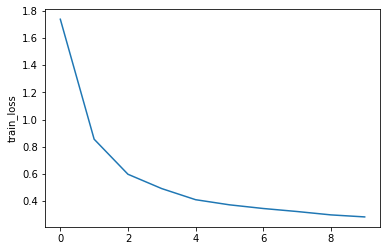

Training accuracy: 96.54
Testing accuracy: 96.69


In [ ]:
# training
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

if args["all_clients"]: 
  print("Aggregation over all clients")
  w_locals = [w_glob for i in range(args["num_users"])]
for iter in range(args["epochs"]):
  loss_locals = []
  if not args["all_clients"]:
    w_locals = []
  m = max(int(args["frac"] * args["num_users"]), 1)
  idxs_users = np.random.choice(range(args["num_users"]), m, replace=False)
  for idx in idxs_users:
    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
    w, loss = local.train(net=copy.deepcopy(net_glob).to(args["device"]))
    if args["all_clients"]:
      w_locals[idx] = copy.deepcopy(w)
    else:
      w_locals.append(copy.deepcopy(w))
    loss_locals.append(copy.deepcopy(loss))
  
  # update global weights
  w_glob = FedAvg(w_locals)

  # copy weight to net_glob
  net_glob.load_state_dict(w_glob)

  # print loss
  loss_avg = sum(loss_locals) / len(loss_locals)
  print('Round {:3d}, Average loss {:.3f}\r\n'.format(iter, loss_avg))
  loss_train.append(loss_avg)


# plot loss curve
plt.figure()
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')
plt.show()

# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))

## Results comparison

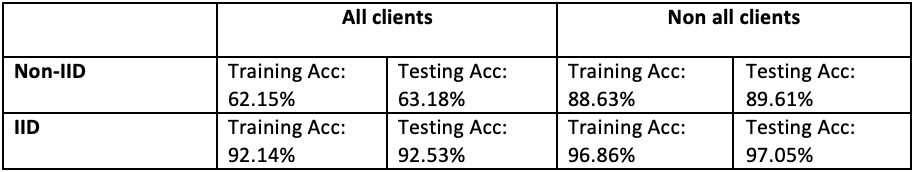

# Federated Transfer Learning with PyTorch

Federated Transfer Learning (FTL) was introduced in [Secure federated transfer Learning](https://ieeexplore.ieee.org/abstract/document/9076003) to improve statistical models under a data federation that allow knowledge to be shared without compromising user privacy, and enable complementary knowledge to be transferred in the network.
 
To make a simple demonstration, we are going to build a global model (MNIST) and transmit this model over different simulated clients for training and updating.

## Essential Library/Packages

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from os.path import exists

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

First, we reload MNIST dataset and split the data to build public model by the following function, called splitData.

## Data spliter

In [ ]:
def splitData(r, dataset_train):
  result = []
  for i in r:
      result.append(dataset_train[i])
  return result

## Public model training

Now, we define a function to train and evaluate the accuracy and loss after training public model

In [ ]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, save_dir = './Global_CNN.pt'):
    model_name = save_dir
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True, min_lr=1e-10)
    
    valid_loss_min = np.Inf # track change in validation loss
    epoch_train_loss =[]
    epoch_val_loss =[]
    
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # train
        model.train()
        for data, target in trainloader:
            # move tensors to GPU if CUDA is available
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        
        # validation
        model.eval()
        y_pred = np.array([],dtype='i')
        y_truth = np.array([],dtype='i')
        with torch.no_grad():
            for data, target in validloader:
                # move tensors to GPU if CUDA is available
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()*data.size(0)
                y_pred = np.concatenate((y_pred, np.argmax(output.clone().detach().cpu().numpy(),axis=1)))
                y_truth = np.concatenate((y_truth, target.clone().detach().cpu().numpy()))
        
        # calculate average losses
        train_loss = train_loss/len(trainloader.sampler)
        valid_loss = valid_loss/len(validloader.sampler)
        epoch_train_loss.append(train_loss)
        epoch_val_loss.append(valid_loss)
        
        acc = accuracy_score(y_truth, y_pred)
        rec = recall_score(y_truth, y_pred, average='macro')
        prec = precision_score(y_truth, y_pred, average='macro')
        f1 = f1_score(y_truth, y_pred, average='macro')
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.2f} \tF1-Score: {:.2f}'.format(
        epoch, train_loss, valid_loss, acc, f1))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), model_name)
            valid_loss_min = valid_loss
            
        scheduler.step(valid_loss)
    
    return 

## Public dataset and client dataset preparation

Reloading MNIST dataset for preparing to build a public model, and later we will transmit this model to clients.

In [ ]:
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

PUBLIC_TRAIN = range(0, 40000)
PUBLIC_TEST = range(0, 7000)
CLIENT_TRAIN = range(40000,len(dataset_train))
CLIENT_TEST = range(7000,len(dataset_test))

public_dataset_train = splitData(PUBLIC_TRAIN, dataset_train)
public_dataset_test = splitData(PUBLIC_TEST, dataset_test)

public_train_loader = DataLoader(public_dataset_train, batch_size=32)
public_val_loader = DataLoader(public_dataset_test, batch_size=32)

client_dataset_train = splitData(CLIENT_TRAIN, dataset_train)
client_dataset_test = splitData(CLIENT_TEST, dataset_test)

client_train_loader = DataLoader(client_dataset_train, batch_size=32)
client_val_loader = DataLoader(client_dataset_test, batch_size=32)

model = CNNMnist(args=args)

if (exists('./Global_CNN.pt')):
  print('Loaded Previous Global Model...')
  model.load_state_dict(torch.load('./Global_CNN.pt'))
  print(model)
else:
  print('Training global model first...')
  # send model
  model.to(DEVICE)
  # set optimizer and criterion
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'])
  scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True, min_lr=1e-10)
        
  # train global model if no weight is loaded
  train(args['epochs'], public_train_loader, public_val_loader, model, optimizer, criterion)
        
  model.cpu()
  model.load_state_dict(torch.load('./Global_CNN.pt'))
  print(model)

  # copy weights
w_glob = model.state_dict()

Training global model first...
Epoch: 1 	Training Loss: 1.073850 	Validation Loss: 0.246893 	Accuracy: 0.93 	F1-Score: 0.93
Validation loss decreased (inf --> 0.246893).  Saving model ...
Epoch: 2 	Training Loss: 0.434391 	Validation Loss: 0.170669 	Accuracy: 0.95 	F1-Score: 0.95
Validation loss decreased (0.246893 --> 0.170669).  Saving model ...
Epoch: 3 	Training Loss: 0.333791 	Validation Loss: 0.131024 	Accuracy: 0.96 	F1-Score: 0.96
Validation loss decreased (0.170669 --> 0.131024).  Saving model ...
Epoch: 4 	Training Loss: 0.285894 	Validation Loss: 0.115869 	Accuracy: 0.96 	F1-Score: 0.96
Validation loss decreased (0.131024 --> 0.115869).  Saving model ...
Epoch: 5 	Training Loss: 0.264100 	Validation Loss: 0.103631 	Accuracy: 0.96 	F1-Score: 0.96
Validation loss decreased (0.115869 --> 0.103631).  Saving model ...
Epoch: 6 	Training Loss: 0.244776 	Validation Loss: 0.095604 	Accuracy: 0.97 	F1-Score: 0.97
Validation loss decreased (0.103631 --> 0.095604).  Saving model ...
Ep

## Apply CORAL for calculating loss

In Federated Transfer Learning, we will use CORAL (Correlation Alignment for Deep Domain Adaptation) for calculating loss. CORAL can learn a nonlinear transformation that aligns correlations of layer activations in deep neural networks (Deep CORAL)

In [ ]:
def CORAL(source, target):
    # this implementation comes from https://github.com/SSARCandy/DeepCORAL
    d = source.data.shape[1]

    # source covariance
    xm = torch.mean(source, 0, keepdim=True) - source
    xc = xm.t() @ xm

    # target covariance
    xmt = torch.mean(target, 0, keepdim=True) - target
    xct = xmt.t() @ xmt

    # frobenius norm between source and target
    loss = torch.mean(torch.mul((xc - xct), (xc - xct)))
    loss = loss/(4*d*d)

    return loss

## Layer Freezing

Freezing a layer prevents its weights from being modified. This technique is often used in transfer learning, where the base model(trained on some other dataset)is frozen. Therefore, we need a method to do that particular function.

In [ ]:
def freeze_layer(model, num_layers):
    ct = 0
    for child in model.children():
        ct += 1
        if ct <= num_layers:
            for param in child.parameters():
                param.requires_grad = False

## Transfer Learning for each round

The below is an added part that differs from Federated Learning, which is Transfer Learning among clients.

In [ ]:
def transfer_learning(local_model, local_dataloader, public_dataloader, coral_lambda):
    # use coral and calculate forward with local model on public dataset and own dataset
    local_model.train()
    local_model.to(DEVICE)
        
    opt = torch.optim.SGD(local_model.parameters(),
                             lr=args['lr'], 
                             weight_decay= args['weight_decay'], 
                             momentum = args['momentum'])
    criterion = torch.nn.CrossEntropyLoss()
        
    for epoch in range(args['local_ep']):
        client_dataset = local_dataloader.__iter__()
        for source_img, source_label in public_dataloader:
            try:
                target_img, target_label = next(client_dataset)
            except StopIteration:
                client_dataset = local_dataloader.__iter__()
                target_img, target_label = next(client_dataset)

            source_img = source_img.to(DEVICE)
            source_label = source_label.to(DEVICE)
            target_img = target_img.to(DEVICE)
            target_label = target_label.to(DEVICE)
                
            opt.zero_grad()
                
            # forward
            out_source = local_model(source_img)
            out_target = local_model(target_img)
                
            # calculate loss
            cl_loss_source = criterion(out_source, source_label)
            cl_loss_target = criterion(out_target, target_label)
                
            # calculate CORAL
            coral_loss = CORAL(out_source, out_target)
                
            total_loss =  coral_lambda * coral_loss + cl_loss_target + cl_loss_source
                
            total_loss.backward()
                
            opt.step()
                
    local_model.to("cpu")

## Local Evaluation

After finishing transfer leanring, the loss, accuracy, recall, precision, and f1-score will be calculated as below.

In [ ]:
def local_evaluation(model, test_dataloader, train_dataloader):
        model.eval()
        model.to(DEVICE)
        
        loss = 0.0
        criterion = torch.nn.CrossEntropyLoss()
        
        y_pred = np.array([],dtype='i')
        y_truth = np.array([],dtype='i')
        with torch.no_grad():
            for data,target in test_dataloader:
                data, target = data.to(DEVICE), target.to(DEVICE)

                outputs = model(data)
                loss += criterion(outputs, target).item() * data.size(0)

                y_pred = np.concatenate((y_pred, np.argmax(outputs.clone().detach().cpu().numpy(),axis=1)))
                y_truth = np.concatenate((y_truth, target.clone().detach().cpu().numpy()))

                if DEVICE == "cuda": torch.cuda.empty_cache()
        model.to("cpu")
        
        test_loss = loss / len(train_dataloader)
        acc = accuracy_score(y_truth, y_pred)
        rec = recall_score(y_truth, y_pred, average='macro')
        prec = precision_score(y_truth, y_pred, average='macro')
        f1 = f1_score(y_truth, y_pred, average='macro')
            
        return test_loss, acc, rec, prec, f1

## Update after each local epoch

Also, we define a new local update function (represent for each client)

In [ ]:
def local_update(model, dataloader):
        model.train()
        model.to(DEVICE)
        
        opt = torch.optim.SGD(model.parameters(),
                             lr=args['lr'], 
                             weight_decay= args['weight_decay'], 
                             momentum = args['momentum'])
        criterion = torch.nn.CrossEntropyLoss()
        
        for epoch in range(args['local_ep']):
            for data,target in dataloader:
                data, target = data.to(DEVICE), target.to(DEVICE)

                opt.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, target)

                loss.backward()
                opt.step() 
        
        model.to("cpu")
        return model

## Training and Testing

Let's start to perform a simulation for Federated Transfer Learning

Aggregation over all clients
Round 0: 	 Client 4 Accuracy: 0.9906666666666667 	Recall: 0.9905506284798407 	Precission:0.9908033567179115 	F1-score: 0.9906437469933635
Round   0, Average loss 0.272

Round 1: 	 Client 9 Accuracy: 0.9913333333333333 	Recall: 0.9911946214505664 	Precission:0.9914101496688408 	F1-score: 0.9912816287147646
Round   1, Average loss 0.258



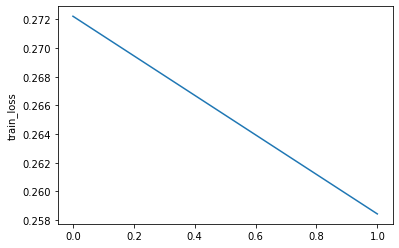

Training accuracy: 97.96
Testing accuracy: 98.04


In [ ]:
# freeze some layer of the model
freeze_layer(model,2)

# training
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
args["num_users"] = 10
args["epochs"] = 2

if args["all_clients"]: 
  print("Aggregation over all clients")
  w_locals = [w_glob for i in range(args["num_users"])]
for iter in range(args["epochs"]):
  loss_locals = []
  if not args["all_clients"]:
    w_locals = []
  m = max(int(args["frac"] * args["num_users"]), 1)
  idxs_users = np.random.choice(range(args["num_users"]), m, replace=False)
  for idx in idxs_users:
    local = local_update(copy.deepcopy(model), copy.deepcopy(client_train_loader))
    w = local.state_dict()

    if args["all_clients"]:
      w_locals[idx] = copy.deepcopy(w)
    else:
      w_locals.append(copy.deepcopy(w))

    transfer_learning(local, copy.deepcopy(client_train_loader), copy.deepcopy(public_train_loader), args['lambda_coral'])

    test_loss, acc, rec, prec, f1 = local_evaluation(copy.deepcopy(local), copy.deepcopy(client_val_loader), copy.deepcopy(client_train_loader))

    print(f"Round {iter}: \t Client {idx} Accuracy: {acc} \tRecall: {rec} \tPrecission:{prec} \tF1-score: {f1}")

    loss_locals.append(copy.deepcopy(test_loss))

  # update global weights
  w_glob = FedAvg(w_locals)

  # copy weight to net_glob
  net_glob.load_state_dict(w_glob)

  # print loss
  loss_avg = sum(loss_locals) / len(loss_locals)
  print('Round {:3d}, Average loss {:.3f}\r\n'.format(iter, loss_avg))
  loss_train.append(loss_avg)


# plot loss curve
plt.figure()
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')
plt.show()

# testing
model.eval()
acc_train, loss_train = test_img(model, dataset_train, args)
acc_test, loss_test = test_img(model, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))

After training and testing, we found that the accuracy have been improved despite the fact that the epoch was reduced to 2.

- Training accuracy: 97.96

- Testing accuracy: 98.04

# Comparison

After running two algorithms FL and FTL, the final result in FTL is better accuracy for both training and testing comparing with FL.

- Federated Learning: 
   Training accuracy: 96.54, Testing accuracy: 96.69
- Federated Transfer Learning: 
   Training accuracy: 97.96, Testing accuracy: 98.04

# Reference

- https://github.com/SSARCandy/DeepCORAL
- https://github.com/AshwinRJ/Federated-Learning-PyTorch
- https://github.com/mania087/HAR-Federated-Transfer-Learning-in-Pytorch